# Recurrent Network

## What is it and Why?

A RNN is a prediction model used in Natural Language Processing (NLP). Usually it is used to predict a next word after another or a whole sentence (or even many phrases). 

For example, if we have to predict what comes next after 'My like likes to drink [.......]', one may say milk while others guess water. A model is trained on many other phrases and using the data it's seen previously, it tries to output a word that is the most likely.

More details about NLP will be covered in later posts and here I will only show what and how I used a recurrent model.

The goal is to generate headlines given a starting word. Due to the limitation of time and computing power, a model I will show later may not be working very well but it still demonstrates how to use recurrent model to predict following words.

Next is an example generation of a headline using the phrase "let's start this post by" with model_20_500 model which will be shown shortly.

In [95]:
generate_headlines(model_20_500, ["let's start this post by"], input_length=20, rnn_size=500)

INFO:tensorflow:Restoring parameters from model/model_20_500
Model model_20_500 Restored


["<START> let's start this post by facebook privacy scandal ? a guide for the social network can help shop online"]

## Data Exploration

The data I used is from UC Berkeley's CS182 (Designing, Visualizing and Understanding Deep Neural Networks). However, the page is currently removed and I do not know if I can share it without their saying so, I don't think I can share it. But similar data can be downloaded from Kaggle's Dataset.

In [1]:
from segtok import tokenizer
from collections import Counter
import tensorflow as tf
import numpy as np
import json
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/'

with open(data_path+'headline_generation_dataset_processed.json', "r") as f:
    dataset = json.load(f)

with open(data_path+'headline_generation_vocabulary.txt', "r") as f:
    vocabulary = f.read().split("\n")

In [3]:
print(f'Number of data samples is {len(dataset)}')
print(f'Number of vocabulary is {len(vocabulary)}')

Number of data samples is 89514
Number of vocabulary is 10000


First, let's examine what dataset looks like.

In [7]:
dataset[0]

{'cut': 'training',
 'mask': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 'numerized': [1958,
  11,
  5,
  1,
  256,
  6490,
  19,
  895,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 'title': 'Forget the Apple Watch. Set Reminders With These Elegant Mechanical Timepieces',
 'url': 'https://www.bloomberg.com/news/articles/2018-04-06/forget-the-apple-watch-set-reminders-with-these-elegant-mechanical-timepieces'}

This data is already preprocessed so that all headlines have the same fixed length. Some headlines may be shorter than the other so to make them the same, padding was added to match.

1. cut : indicates whether a sample is training or validation
2. title : News Headlines that we are going to use for both training and evaluation
3. url : The origin of each headline
4. mask : If True, it is an actual word in a headline. If False, it is a padding
5. numerzied : Maps a word to an index of vocabulary

In [8]:
vocabulary[:10]

['<START>', 'UNK', 'PAD', 'to', ',', 'apple', 'facebook', 'google', "'", 'in']

In [4]:
# indices for start, padding and unknown
start, pad, unk = 0, 2, 1

<b>START</b> indicates the beginning position in a headline.<br> 
<b>PAD</b> indicates a padding added to a headline to match the length.<br>
<b>UNK</b> indicates an unknown word. This happens when vocabulary doesn't have a word which is used in samples.

The words in vocabulary are already sorted so each index corresponds to numerized values.

First thing to do is to make a mapping from word to index so that we can use numerized element in samples.

In [5]:
vocab_size = len(vocabulary)

word_to_index = {word:index for index, word in enumerate(vocabulary)}
word_to_index['google']

7

Another thing I need was translating a list of numerized to a string headline.

In [6]:
sample = dataset[10]

sample_headline = sample['title']
sample_mask = sample['mask']
sample_numerized = sample['numerized']

In [7]:
def translate_numerized(numerized):
    
    headline = [vocabulary[word] for word in numerized if vocabulary[word] != 'PAD']
    
    return ' '.join(headline)

In [8]:
translate_numerized(sample_numerized)

'can you pass the intelligence test solved by millions on facebook ?'

Another thing I need is to numerize a given sentence.

In [9]:
def numerize(sentence):
    
    tokens = tokenizer.word_tokenizer(sentence)
    
    numerized = [word_to_index.get(token.lower(), unk) for token in tokens]
    
    return numerized

In [10]:
numerize(sample_headline)

[92, 47, 2602, 11, 884, 438, 7274, 34, 932, 10, 6, 33]

In the dataset, any non-alphabet characters are treated as a separate word and that is why there is a space between the question mark and 'facebook' in the sample. 

In [11]:
train_data = [data for data in dataset if data['cut'] == 'training']
valid_data = [data for data in dataset if data['cut'] == 'validation']

len(train_data), len(valid_data)

(88568, 946)

# Code

## Class Definition

In [12]:
class Model():

    def __init__(self, input_length, vocab_size, rnn_size, learning_rate=1e-4, momentum=.85, decay=.9, beta1=.9, beta2=.99):
        
        self.input_num = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets_mask = tf.placeholder(tf.bool, shape=[None, input_length])

        # Each vocab will have an embedding of rnn_size
        embedding = tf.get_variable('word_embeddings', [vocab_size, rnn_size])
        
        # Look up embedding of input_num
        input_emb = tf.nn.embedding_lookup(embedding, self.input_num)

        # LSTM cell for rnn
        lm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
        lm_cell = tf.nn.rnn_cell.DropoutWrapper(lm_cell, .5, 1)
        
        # Run sequence of LSTM cells
        # dynamic_rnn returns outputs and states.
        # states are not used here so I didn't save it
        outputs, _ = tf.nn.dynamic_rnn(lm_cell, input_emb, dtype=tf.float32)

        self.logits = tf.layers.dense(outputs, vocab_size)
        
        # mask weights so that only non-pad words are considered
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.targets, self.logits, weights=tf.cast(self.targets_mask, dtype=np.float32))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2).minimize(self.loss)

        self.saver = tf.train.Saver()

In [13]:
def load_data(dataset, batch_size):
    
    batch = np.random.choice(dataset, size=batch_size, replace=False)
    
    batch_numerized = [d['numerized'] for d in batch]

    # Shift words and add start token
    start_tokens = np.array([0]*batch_size).reshape(-1, 1)
    batch_input = np.concatenate((start_tokens, batch_numerized), axis=1)
    
    # Remove Target token
    batch_input = batch_input[:, :-1]
    
    # Set Target
    batch_target = batch_numerized
    
    # Mask of each words
    batch_target_mask = np.array([a['mask'] for a in batch])
    
    return batch_input, batch_target, batch_target_mask

## Train

In [14]:
def train_model(model_name, input_length=20, rnn_size=750, 
                learning_rate=1e-3, batch_size=300, beta1=.85, beta2=.8, 
                epochs=50, iter_ver=10, load_model=True):
  
    tf.reset_default_graph() 

    if not os.path.exists('model/'):
        os.mkdir('model/')

    model_path = 'model/'

    model = Model(input_length=input_length, vocab_size=vocab_size, rnn_size=rnn_size, learning_rate=learning_rate, beta1=beta1, beta2=beta2)

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        if load_model:
            try:
                model.saver.restore(sess, model_path+model_name)
                print(f'Model {model_name} Restored')
            except:
                print(f'Training a new Model : {model_name}')
                
        else:
            print(f'Training a new Model : {model_name}')

        
        train_losses = []
        valid_losses = []
        
        
        for i in range(epochs):

            start = time.time()

            for j in range(300):

                input_num, batch_target, batch_target_mask = load_data(train_data, batch_size)

                feed = {model.input_num: input_num, model.targets: batch_target, model.targets_mask: batch_target_mask}

                train_loss, j = sess.run([model.loss, model.optimizer], feed_dict=feed)

            end = time.time()
            
            
            # Validation Loss
            
            valid_input, valid_target, valid_target_mask = load_data(valid_data, batch_size)

            feed = {model.input_num: valid_input, model.targets: valid_target, model.targets_mask: valid_target_mask}

            valid_loss = sess.run(model.loss, feed_dict=feed)


            if (i+1) % iter_ver == 0:
                print(f'Time : {int(end - start)} Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')
  
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

      
            # Save at every 10 epochs
            if (i+1) % 10 == 0:
                model.saver.save(sess, model_path+model_name)
                print(f'\n===== Model {model_name} saved =====\n')
          
          
    return (train_losses, valid_losses)

In [15]:
# model with different rembedding sizes

model_20_250 = 'model_20_250'
model_20_500 = 'model_20_500'
model_20_750 = 'model_20_750'
model_20_1000 = 'model_20_1000'

In [29]:
# Took about 7 minutes

model_20_250_losses = train_model(model_name=model_20_250, rnn_size=250, iter_ver=1, epochs=20, load_model=False)

Training a new Model : model_20_250
Time : 19 Epoch : 1 Train Loss : 6.521451950073242 Valid Loss : 6.604078769683838
Time : 19 Epoch : 2 Train Loss : 6.191676139831543 Valid Loss : 6.258332252502441
Time : 19 Epoch : 3 Train Loss : 5.802998065948486 Valid Loss : 5.972076892852783
Time : 18 Epoch : 4 Train Loss : 5.657375812530518 Valid Loss : 5.823077201843262
Time : 19 Epoch : 5 Train Loss : 5.5470499992370605 Valid Loss : 5.685995578765869
Time : 18 Epoch : 6 Train Loss : 5.4077229499816895 Valid Loss : 5.600042343139648
Time : 18 Epoch : 7 Train Loss : 5.407564163208008 Valid Loss : 5.594792366027832
Time : 18 Epoch : 8 Train Loss : 5.223485469818115 Valid Loss : 5.543225288391113
Time : 19 Epoch : 9 Train Loss : 5.269318103790283 Valid Loss : 5.4890456199646
Time : 18 Epoch : 10 Train Loss : 5.151086807250977 Valid Loss : 5.4974822998046875
Time : 18 Epoch : 11 Train Loss : 5.090558052062988 Valid Loss : 5.521342754364014
Time : 18 Epoch : 12 Train Loss : 4.9680047035217285 Valid 

In [32]:
# Took about 10 minutes

model_20_500_losses = train_model(model_name=model_20_500, rnn_size=500, iter_ver=1, epochs=20, load_model=False)

Training a new Model : model_20_500
Time : 31 Epoch : 1 Train Loss : 6.290328502655029 Valid Loss : 6.409896373748779
Time : 30 Epoch : 2 Train Loss : 5.906001567840576 Valid Loss : 5.892825126647949
Time : 30 Epoch : 3 Train Loss : 5.54813289642334 Valid Loss : 5.746621608734131
Time : 30 Epoch : 4 Train Loss : 5.278981685638428 Valid Loss : 5.661812782287598
Time : 30 Epoch : 5 Train Loss : 5.29741907119751 Valid Loss : 5.633823871612549
Time : 30 Epoch : 6 Train Loss : 5.061626434326172 Valid Loss : 5.496407985687256
Time : 30 Epoch : 7 Train Loss : 5.070347785949707 Valid Loss : 5.540763854980469
Time : 30 Epoch : 8 Train Loss : 4.845116138458252 Valid Loss : 5.439145565032959
Time : 30 Epoch : 9 Train Loss : 4.731771469116211 Valid Loss : 5.389241695404053
Time : 30 Epoch : 10 Train Loss : 4.6543989181518555 Valid Loss : 5.339622974395752

===== Model model_20_500 saved =====

Time : 30 Epoch : 11 Train Loss : 4.660418510437012 Valid Loss : 5.396697044372559
Time : 30 Epoch : 12 T

In [69]:
# Took about 16 minutes

model_20_750_losses = train_model(model_name=model_20_750, rnn_size=750, iter_ver=1, epochs=20, load_model=False)

Training a new Model : model_20_750
Time : 47 Epoch : 1 Train Loss : 6.1389970779418945 Valid Loss : 6.1926984786987305
Time : 46 Epoch : 2 Train Loss : 5.594339847564697 Valid Loss : 5.8611931800842285
Time : 47 Epoch : 3 Train Loss : 5.416676044464111 Valid Loss : 5.625517845153809
Time : 46 Epoch : 4 Train Loss : 4.947951316833496 Valid Loss : 5.519547939300537
Time : 47 Epoch : 5 Train Loss : 4.95191764831543 Valid Loss : 5.4528422355651855
Time : 47 Epoch : 6 Train Loss : 4.656552314758301 Valid Loss : 5.410458564758301
Time : 46 Epoch : 7 Train Loss : 4.487500190734863 Valid Loss : 5.385641574859619
Time : 47 Epoch : 8 Train Loss : 4.506504535675049 Valid Loss : 5.50782585144043
Time : 47 Epoch : 9 Train Loss : 4.389082431793213 Valid Loss : 5.436454772949219
Time : 46 Epoch : 10 Train Loss : 4.239155292510986 Valid Loss : 5.48450231552124

===== Model model_20_750 saved =====

Time : 47 Epoch : 11 Train Loss : 4.178558826446533 Valid Loss : 5.415424823760986
Time : 47 Epoch : 12

In [70]:
# Took about 22 minutes

model_20_1000_losses = train_model(model_name=model_20_1000, rnn_size=1000, iter_ver=1, epochs=20, load_model=False)

Training a new Model : model_20_1000
Time : 67 Epoch : 1 Train Loss : 6.116085529327393 Valid Loss : 6.189640045166016
Time : 67 Epoch : 2 Train Loss : 5.5112504959106445 Valid Loss : 5.724303245544434
Time : 67 Epoch : 3 Train Loss : 5.151978969573975 Valid Loss : 5.583501815795898
Time : 67 Epoch : 4 Train Loss : 5.004917621612549 Valid Loss : 5.457799911499023
Time : 67 Epoch : 5 Train Loss : 4.716437339782715 Valid Loss : 5.398298740386963
Time : 67 Epoch : 6 Train Loss : 4.456024646759033 Valid Loss : 5.4200758934021
Time : 67 Epoch : 7 Train Loss : 4.233898639678955 Valid Loss : 5.400672912597656
Time : 67 Epoch : 8 Train Loss : 4.05080509185791 Valid Loss : 5.503702163696289
Time : 67 Epoch : 9 Train Loss : 3.8865251541137695 Valid Loss : 5.429373741149902
Time : 67 Epoch : 10 Train Loss : 3.7687785625457764 Valid Loss : 5.409214019775391

===== Model model_20_1000 saved =====

Time : 67 Epoch : 11 Train Loss : 3.8164422512054443 Valid Loss : 5.518129348754883
Time : 67 Epoch : 

In [17]:
model_20_250_losses = pd.read_csv('./losses/model_20_250_losses')
model_20_500_losses = pd.read_csv('./losses/model_20_500_losses')
model_20_750_losses = pd.read_csv('./losses/model_20_750_losses')
model_20_1000_losses = pd.read_csv('./losses/model_20_1000_losses')

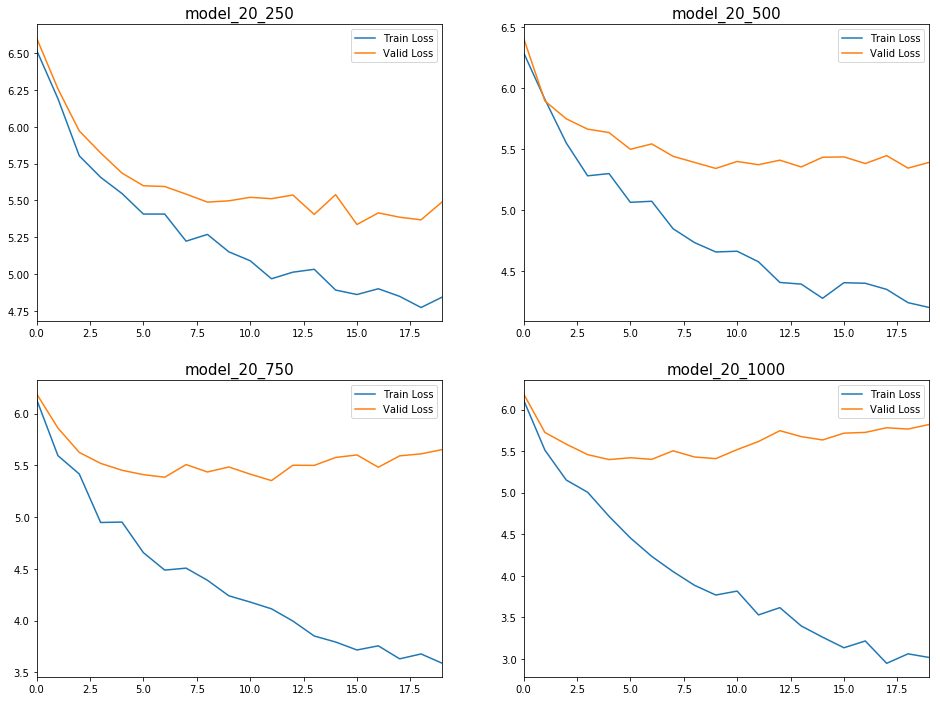

In [33]:
fix, ax = plt.subplots(2, 2, figsize=(16, 12))

model_20_250_losses.plot(ax=ax[0][0])
ax[0][0].set_title('model_20_250', size=15)

model_20_500_losses.plot(ax=ax[0][1])
ax[0][1].set_title('model_20_500', size=15)

model_20_750_losses.plot(ax=ax[1][0])
ax[1][0].set_title('model_20_750', size=15)

model_20_1000_losses.plot(ax=ax[1][1])
ax[1][1].set_title('model_20_1000', size=15);

As the number of <b>rnn_size</b> increases, it overfits faster that we can see from the graph valid loss increases as well. However by the looks of the plots, using small rnn_size stops learning earlier than larger sizes so such parameters should be chosen carefully by exploring more combinations.

## Prediction

### Headline Generation

In [64]:
def generate_headlines(model_name, starting_words, input_length, rnn_size):
  
    tf.reset_default_graph() 

    with tf.Session() as sess:

        model_path = 'model/'
        model = Model(input_length=input_length, rnn_size=rnn_size, vocab_size=vocab_size)

        try:
            model.saver.restore(sess, model_path+model_name)
            print(f'Model {model_name} Restored')
            
        except:
            print(f'Model {f} does not exist')
            return None
          
        generated_sentences = []
        

        
        for starting_word in starting_words:

            generated = [start] + numerize(starting_word)

            while len(generated) < input_length:

                # Pad current generated sentence to match the input_length
                padded = generated[:input_length] + [pad] * (input_length - len(generated))
                padded = np.array([padded])

                feed = {model.input_num : padded}

                logits = sess.run([model.logits], feed_dict=feed)

                last_logits = logits[0][0][len(generated)-1][5:]

                generated.append(np.argmax(last_logits)+5)


            generated_sentence = translate_numerized(generated)

            generated_sentences.append(generated_sentence)
            
    return generated_sentences

In [65]:
starting_words = ['court', 'samsung', 'apple', 'google', 'google and apple', 'google and samsung', 'samsung and apple']

In [66]:
pred_20_250 = generate_headlines(model_20_250, starting_words, input_length=20, rnn_size=250)
pred_20_500 = generate_headlines(model_20_500, starting_words, input_length=20, rnn_size=500)
pred_20_750 = generate_headlines(model_20_750, starting_words, input_length=20, rnn_size=750)
pred_20_1000 = generate_headlines(model_20_1000, starting_words, input_length=20, rnn_size=1000)

INFO:tensorflow:Restoring parameters from model/model_20_250
Model model_20_250 Restored
INFO:tensorflow:Restoring parameters from model/model_20_500
Model model_20_500 Restored
INFO:tensorflow:Restoring parameters from model/model_20_750
Model model_20_750 Restored
INFO:tensorflow:Restoring parameters from model/model_20_1000
Model model_20_1000 Restored


In [67]:
pred_20_250

['<START> court says apple must pay $ 1 billion in taxes in patent case - sources say wsj says wsj',
 '<START> samsung loses bid for patent infringement case against apple in germany case against samsung galaxy tab : what it',
 "<START> apple is said for plan for tv series with new iphone x - here's what it looks like in",
 "<START> google says it will be forgotten ' right ' in china ' eu antitrust probe by mps over data",
 "<START> google and apple pay in china over iphone 5 ' month ' in china ' in the u.s .",
 '<START> google and samsung are said in talks with mobile software on mobile phones - wsj says it will be',
 '<START> samsung and apple are said in talks with samsung over tablet sales in china - report says no iphone']

In [68]:
pred_20_500

['<START> court rules in favor of apple iphone 4s delayed in china after report of iphone 4s launch claims in',
 '<START> samsung loses bid for apple in japan patent case : u.s. appeals court ruling on samsung phone ban :',
 '<START> apple iphone 5 : review roundup : the best deals ! the world ? not so much yet ?',
 '<START> google and facebook are the most in the high for the tech industry market market cap in the week',
 "<START> google and apple face new privacy concerns in france probe of youtube ads in india crackdown probe says '",
 "<START> google and samsung are not a war on the apple car project : ' we are not so much",
 '<START> samsung and apple end patent fight with u.s. smartphone market war with u.s . . . ) says on']

In [69]:
pred_20_750

['<START> court says facebook must pay $ 1 billion in virtual reality lawsuit case case case case against facebook data',
 '<START> samsung says it will release a new apple tv and security for its own xbox one shows what it',
 '<START> apple iphone 4s event : watch review : what it happened on how the ipad pro fire is better',
 "<START> google launches new chrome browser for android users with apple's ipad and iphone 8 owners on mac devices in",
 '<START> google and apple are reportedly building a car that can compete with the iphone that that could be affected',
 '<START> google and samsung face smartphone makers in europe trial for android devices and more control 8.1 of times android',
 "<START> samsung and apple are reportedly a new smartphone in the u.s . . . . . . it's great"]

In [70]:
pred_20_1000

['<START> court says samsung case loss on apple is infringe patents in patent case case against filing suit against suit',
 '<START> samsung galaxy products beats apple as new galaxy s smartphone 3 drop in the u.s . . on net',
 '<START> apple says it will add more than itunes in the u.s . . . 100 percent because why is',
 '<START> google says it will pay $ 100 million in eu over security in security and for the company will',
 '<START> google and apple have a huge investment in the cloud wars with technology and amazon and not complicated .',
 "<START> google and samsung in sign deal for a new deal with machine learning and tv shows why they can't",
 "<START> samsung and apple ' top pick ' for ipad turns too late ' : ' edition isn't not a"]

# Conclusion

In [88]:
# A weird conclusion

generate_headlines(model_20_750, ['to end this post,'], input_length=20, rnn_size=750)

INFO:tensorflow:Restoring parameters from model/model_20_750
Model model_20_750 Restored


['<START> to end this post , a former facebook post has found a new york president in the 2016 -']

Obviously, in the process of building up a model, I got to figure out more about how to properly use LSTM cells from tensorflow and use masking to only extract wanted embeddings. 

There are already many other and much better models than this such as bi-LSTM model, BERT or transformer that could predict and generate much longer sentences.

Each model used in the post, was only trained to generate 20 words at max that the predictions ended before it reached proper ending. This can be easily increased by modifying the data used and padding them more. This will cause the training slower obviously so I could not do it due to the lack of resources.

As mentioned above, I cannot provide the data I used without having their consent but you can still get the weights of each model at [my drive](https://drive.google.com/open?id=1BkG8Xr8eBldwGhhUvazrGCoS5RzPHKM_) and view the full code to load them at [my github](https://github.com/hsong1101/Text-Generation). For the weights, you should download everything to load.

Again, thank you for reading this and if you find any errors, typos or have any suggestions, please let me know.